# importing dependencies

In [1039]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV,StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score
import warnings
warnings.filterwarnings('ignore')

# DATA COLLECTION AND PREPROCESSING

## On training data

In [1040]:
train_data_path = './train.csv'
test_data_path = './test.csv'

In [1041]:
train_df = pd.read_csv(train_data_path)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


1.PassengerId: Unique ID jo har passenger ko diya gaya hai.

2.Pclass: Ticket ka class (1, 2, ya 3). Yeh show karta hai ki passenger kis social class se belong karta hai.

3.Name: Passenger ka naam.

4.Sex: Passenger ka gender (Male ya Female).

5.Age: Passenger ki age.

6.SibSp: Number of siblings or spouses aboard the Titanic. Yeh batata hai ki passenger ke saath kitne siblings ya spouses travel kar rahe the.

7.Parch: Number of parents or children aboard the Titanic. Yeh batata hai ki passenger ke saath kitne parents ya children travel kar rahe the.

8.Ticket: Ticket number.

9.Fare: Ticket price, jo passenger ne pay kiya.

10.Cabin: Cabin number jisme passenger travel kar raha tha (kaafi missing hota hai).

11.Embarked: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton). Yeh batata hai ki passenger kaun se port se Titanic mein chadha tha.

12.Survived: Whether the passenger survived (0 = No, 1 = Yes). Yeh dependent variable hai jo predict karne ka target hota hai (survival prediction).


In [1042]:
print(f"shape: {train_df.shape}")
train_df.info()

shape: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1043]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [1044]:
# dropping the columns with more than 50% missing values
train_df.drop(['Cabin', 'Name', 'Ticket'], axis=1, inplace=True)

In [1045]:
train_df.dropna(inplace=True)
train_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [1046]:
print(f"shape: {train_df.shape}")

shape: (712, 9)


In [1047]:
print(train_df.value_counts('Sex'))
print(train_df.value_counts('Embarked'))

# binarizing the gender
train_df['Sex'].replace({'male' : 0, 'female': 1}, inplace=True)
train_df['Embarked'].replace({'S':0, 'C':1, 'Q': 2}, inplace=True)


Sex
male      453
female    259
Name: count, dtype: int64
Embarked
S    554
C    130
Q     28
Name: count, dtype: int64


In [1048]:
train_df

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,0
1,2,1,1,1,38.0,1,0,71.2833,1
2,3,1,3,1,26.0,0,0,7.9250,0
3,4,1,1,1,35.0,1,0,53.1000,0
4,5,0,3,0,35.0,0,0,8.0500,0
...,...,...,...,...,...,...,...,...,...
885,886,0,3,1,39.0,0,5,29.1250,2
886,887,0,2,0,27.0,0,0,13.0000,0
887,888,1,1,1,19.0,0,0,30.0000,0
889,890,1,1,0,26.0,0,0,30.0000,1


## data cleaning on test data

In [1049]:
testing_data_orignal = pd.read_csv(test_data_path)

In [1050]:
testing_data_orignal.info()
print(testing_data_orignal.columns)
print(testing_data_orignal.isnull().sum())

testing_data_passengerId = testing_data_orignal['PassengerId']
print(testing_data_passengerId)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket      

In [1051]:
testing_data_orignal.drop(['PassengerId','Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [1052]:
mean_age = testing_data_orignal['Age'].mean()
mean_fare = testing_data_orignal['Fare'].mean()

testing_data_orignal["Age"].fillna(round(mean_age), inplace=True)
testing_data_orignal["Fare"].fillna(mean_fare, inplace=True)

testing_data_orignal.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [1053]:
testing_data_orignal['Sex'].replace({'male':0, 'female': 1}, inplace=True)
testing_data_orignal['Embarked'].replace({'S':0, 'C':1, 'Q': 2}, inplace=True)

In [1054]:
testing_data_orignal

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,2
1,3,1,47.0,1,0,7.0000,0
2,2,0,62.0,0,0,9.6875,2
3,3,0,27.0,0,0,8.6625,0
4,3,1,22.0,1,1,12.2875,0
...,...,...,...,...,...,...,...
413,3,0,30.0,0,0,8.0500,0
414,1,1,39.0,0,0,108.9000,1
415,3,0,38.5,0,0,7.2500,0
416,3,0,30.0,0,0,8.0500,0


## EDA

In [1055]:
corr = train_df.corr()

<Axes: >

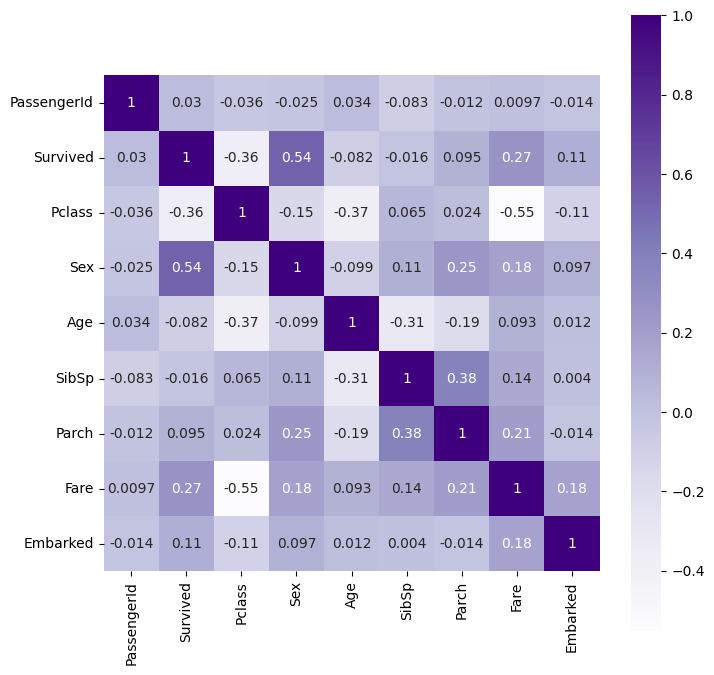

In [1056]:
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, square=True, cmap='Purples')

In [1057]:
# features (indepenedent variables)
X = train_df.drop(['PassengerId','Survived'], axis=1)
# traget (dependent variable)
y = train_df['Survived']

In [1058]:
X.shape, y.shape

((712, 7), (712,))

train test split

In [1059]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=4)

In [1060]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((569, 7), (143, 7), (569,), (143,))

In [1061]:
# random forest classifier model
rfc_model = RandomForestClassifier(n_estimators=60, min_samples_split=3, min_samples_leaf=3, max_depth=15)

### CROSS VALIDATE

In [1062]:
# StratifiedKFold
stratified = StratifiedKFold(n_splits=21, shuffle=True, random_state=6)
# CV accuracy score
cv_accuracy_score =  cross_val_score(rfc_model, X,y, cv=stratified, scoring='accuracy' )
# print(f"CV acc. score: {cv_accuracy_score}")
print(f"CV acc. score mean: {cv_accuracy_score.mean()}")
# CV precision
cv_precision =  cross_val_score(rfc_model, X,y, cv=stratified, scoring='precision' )
# print(f"CV precision: {cv_precision}")
print(f"CV precision mean : {cv_precision.mean()}") 

CV acc. score mean: 0.8062558356676005
CV precision mean : 0.8144215572787002


#### hyperparameter tuning params 

In [1063]:
# params = {
#     'n_estimators': [20,40,60,80,100],
#     'max_depth' : [5,10,15,20],
#     'min_samples_split': [1,2,3,4,5,6,7,8,9,10],
#     'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10],
# }

# rfc_model_CV = GridSearchCV(rfc_model, param_grid=params, cv=5, scoring='accuracy', verbose=10)
# rfc_model_CV.fit(X_train,y_train)

In [1064]:
# print(f"best paramater: {rfc_model_CV.best_params_}")
# print(f"best score: {rfc_model_CV.best_score_}")

In [1065]:
# fitting the best hypertuned model with data 
rfc_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=3,
                       n_estimators=60)

In [1066]:
rfc_model_pred_y = rfc_model.predict(X_train)

In [1067]:
# checking the accuracy of the model
score = accuracy_score(y_train, rfc_model_pred_y)
p_score = precision_score(y_train, rfc_model_pred_y)

print(f"accuracy score is: {(score*100):.2f} %")
print(f"precision score is: {p_score:.2f}")

accuracy score is: 88.93 %
precision score is: 0.92


# Final model

In [1069]:
final_model = rfc_model
final_model.fit(X,y)

final_model_prediction = final_model.predict(testing_data_orignal) 

# CERATING THE DATA FRAME
predicted_df = pd.DataFrame({
    'PassengerId': testing_data_passengerId,
    'Survived': final_model_prediction
})

# SAVING THE DATAFRAME
predicted_df.to_csv('final_titanic_survival_prediction.csv', index=False)
